
# EDA which makes sense

This notebook analyzes the competition data and gives insight on how to proceed with modeling.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
import datetime
from data_sources import *
from sklearn.decomposition import PCA

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

In [2]:
train = pd.read_csv(train)
train_labels = pd.read_csv(train_labels)
test = pd.read_csv(test)

print()
print('Train')
display(train.head())

print()
print('Train_labels')
display(train_labels.head())

print()
print('Test')
display(test.head())

print('Dataframe shapes:', train.shape, train_labels.shape, test.shape)
print()
print(f'Sequence numbering in train_labels: from {train_labels.sequence.min()} to {train_labels.sequence.max()}')
print(f'Sequence numbering in train: from {train.sequence.min()} to {train.sequence.max()}')
print(f'Sequence numbering in test: from {test.sequence.min()} to {test.sequence.max()}')
print()
print(f'Step numbering: from {train.step.min()} to {train.step.max()}')
print()
print(f'Subject numbering in train: from {train.subject.min()} to {train.subject.max()}')
print(f'Subject numbering in test: from {test.subject.min()} to {test.subject.max()}')
print()
print(f'States: {np.unique(train_labels.state)}')



Train


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359



Train_labels


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1



Test


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


Dataframe shapes: (1558080, 16) (25968, 2) (733080, 16)

Sequence numbering in train_labels: from 0 to 25967
Sequence numbering in train: from 0 to 25967
Sequence numbering in test: from 25968 to 38185

Step numbering: from 0 to 59

Subject numbering in train: from 0 to 671
Subject numbering in test: from 672 to 990

States: [0 1]


There are almost 26000 sequences in the training data (25968, to be precise). The `train` dataframe has exactly 60 times more rows than the `train_labels` dataframe (25968 * 60 = 1558080) because every sequence has 60 steps. There are no missing steps, and the steps are numbered from 0 to 59.

We have to predict a binary state for every series (binary classification). Every sequence has 60 * 13 = 780 features.

The train and test subjects are disjoint.

**Insight:**
- As the train and test subjects are different, we cannot use the subject as a feature. On the contrary: we have to make sure that our classifier generalizes to previously unseen subjects. This suggests a GroupKFold cross-validation with the subjects as groups.
- With the 780 features per sequence, feature engineering could play an important role here. Or we might use a deep neural network which operates on the raw data and learns the features itself.

In the following notebook cell, we check how often each subject occurs in the training data. The most infrequent subject occurs only twice; the most frequent subject is a hundred times more frequent; it occurs 199 times. The picture for the test data is similar.

**Insight:**
- If we cross-validate with a simple GroupKFold, the training and validation sets for the different folds will have different sizes. Maybe we can neglect this, maybe we want to take additional measures to have training sets of similar sizes.

472      2
73       5
265      6
519      7
486      7
      ... 
87     129
647    144
635    158
1      175
437    199
Name: sequence count per training subject, Length: 672, dtype: int64
823      8
943     10
973     11
975     11
830     11
      ... 
874     98
865     99
781    103
682    107
748    148
Name: sequence count per test subject, Length: 319, dtype: int64


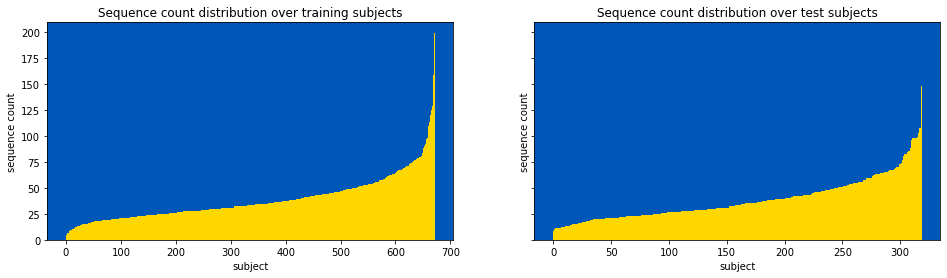

In [3]:
plt.subplots(1, 2, sharey=True, figsize=(16, 4))


def plot_sequence_count_distribution(df, title):
    temp = df.subject.value_counts().sort_values() // 60
    plt.bar(range(len(temp)), temp, width=1)
    plt.xlabel('subject')
    plt.ylabel('sequence count')
    plt.title(f'Sequence count distribution over {title} subjects')
    print(temp.sort_values().rename(f'sequence count per {title} subject'))

plt.subplot(1, 2, 1)
plot_sequence_count_distribution(train, 'training')
plt.subplot(1, 2, 2)
plot_sequence_count_distribution(test, 'test')
plt.show()


While we are looking at the subjects, we can calculate the means of the states per subject and plot them as a histogram (the mean of the state corresponds to the probability that state = 1). We only use subjects with at least 25 sequences for the histogram. If every sequence is in state=1 with 50 % probability, the histogram should show a bell curve with a standard deviation of at most 0.1, but the histogram shows that the standard deviation is higher. The subjects are inherently different. Every subject has its own probability of state=1, and this probability can have any value between 0 and 1. 59 subjects are always in state 0.


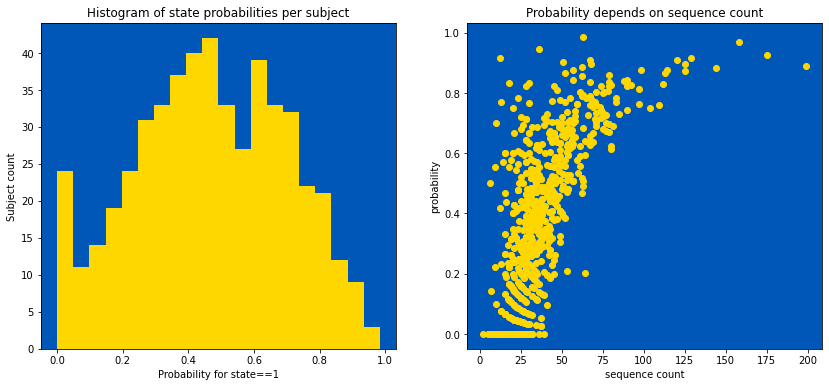


The standard deviation of 0.23 is much higher than 0.1.

Subjects which are always in state 0: 59


In [4]:
temp = train.groupby('sequence').subject.min() # dataframe with one row per sequence
temp = train_labels.merge(temp, on='sequence') # add a column with the labels
temp = temp.groupby('subject').agg({'state': 'mean', 'sequence': 'count'}).rename(columns={'state': 'probability', 'sequence': 'sequence_count'})
temp1 = temp[temp.sequence_count >= 25].probability.rename('Probability of state==1')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(temp1, bins=20)
plt.ylabel('Subject count')
plt.xlabel('Probability for state==1')
plt.title('Histogram of state probabilities per subject')

plt.subplot(1, 2, 2)
plt.scatter(temp.sequence_count, temp.probability)
plt.xlabel('sequence count')
plt.ylabel('probability')
plt.title('Probability depends on sequence count')
plt.show()

print()
print(f"The standard deviation of {temp[temp.sequence_count >= 25].probability.std():.2f} is much higher than 0.1.")
print()
print('Subjects which are always in state 0:', (temp.probability == 0).sum())

**Insight**:
- These views on the data confirms the earlier insight that generalization to previously unseen subjects is important and that the cross-validation strategy has to take this into account.
- The more often a subject occurs in the training data, the higher its probability for state=1. Although we must not use the subject as a feature, we should count how many sequences belong to every subject and use this count as a feature. (I tried it and this feature improved the predictions.)
- The lower left of the scattergram shows some dots which are grouped to hyperbolas. This is an artefact of low sequence counts and cannot be exploited for prediction. (If a subject has only one or two positive sequences, the probability is 1 / sequence count or 2 / sequence count, respectively, and these are the hyperbolas. 

# The sensors

We can plot histograms for all 13 sensors. The histograms show that every sensor has outliers.

**Insight:**
- We will have to deal with outliers. If there are only a few sequences with outliers, we can drop the whole sequences. If most sequences contain outliers, we will need to replace the outliers by more reasonable values rather than dropping them. In other words: It is important to understand whether the outliers are single steps or whole sequences.


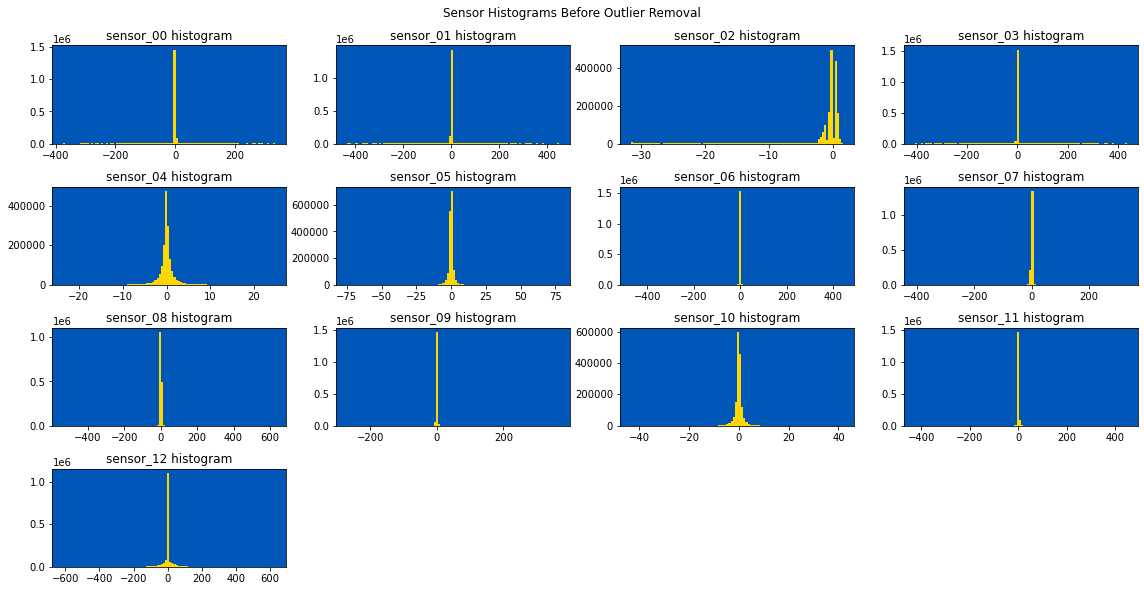

In [5]:
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100)
    plt.title(f"{sensor_name} histogram")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Histograms Before Outlier Removal', y=1.02)
plt.show()

Now let's plot the "inner" part of the histogram after removing 2 % outliers on either side. We see that the sensors differ in their characteristics:
- Most measurements of sensor_02 return multiples of 0.33 (but the values in between occur with a low probability).
- Sensor_08 has discrete values (multiples of 0.1).
- Some sensors look like normal distributions, others (in particular sensor_12) have a long tail.

The distributions look symmetric with the center at 0.

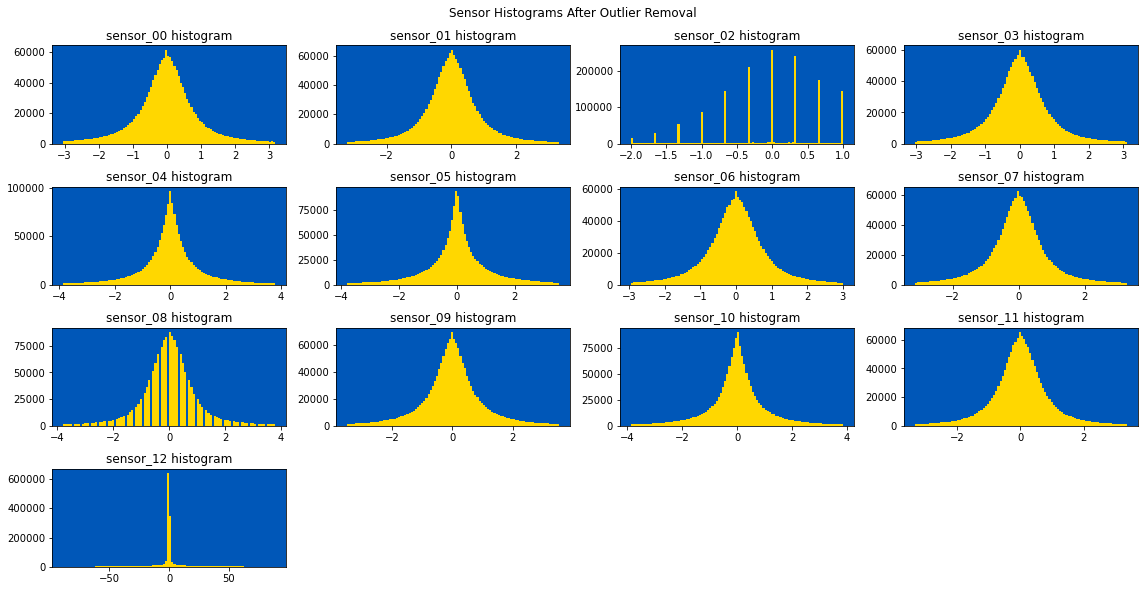

In [6]:
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100,
             range=(train[sensor_name].quantile(0.02),
                    train[sensor_name].quantile(0.98)))
    plt.title(f"{sensor_name} histogram")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Histograms After Outlier Removal', y=1.02)
plt.show()

Sensor_12 has a long tail even if we declare 30 % of the data to be outliers:

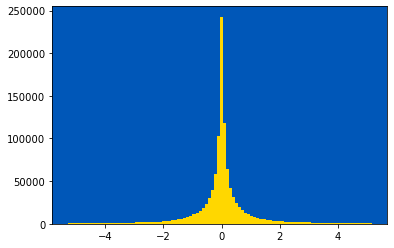

In [7]:
sensor_name = 'sensor_12'
plt.hist(train[sensor_name], bins=100,
         range=(train[sensor_name].quantile(0.15),
                train[sensor_name].quantile(0.85)))
plt.show()


**Insight:**
- As we probably cannot declare 30 % of the data to be outliers, we may want to apply some [non-linear transformation](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation) (e.g., [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)) to the sensor values to get a more normal distribution.

To conclude the analysis of the sensors, let's count the unique values. Although the train dataframe has more than 1.5 million rows, every sensor returns much fewer unique values. It seems that the sensors return discrete values, or they often return a constant value for long time intervals.

In [8]:
print("Count of unique values per sensor:")
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    print(f"{sensor_name}: {len(np.unique(train[sensor_name])):6d}")


Count of unique values per sensor:
sensor_00:  25792
sensor_01:  28326
sensor_02:   4771
sensor_03:  26976
sensor_04: 387971
sensor_05:  22839
sensor_06:  25078
sensor_07:  28147
sensor_08:   1924
sensor_09:  30127
sensor_10: 268478
sensor_11:  28932
sensor_12: 303949


# Time series

We now plot the a few sequences as time series (sequences are from left to right, sensors from top to bottom):

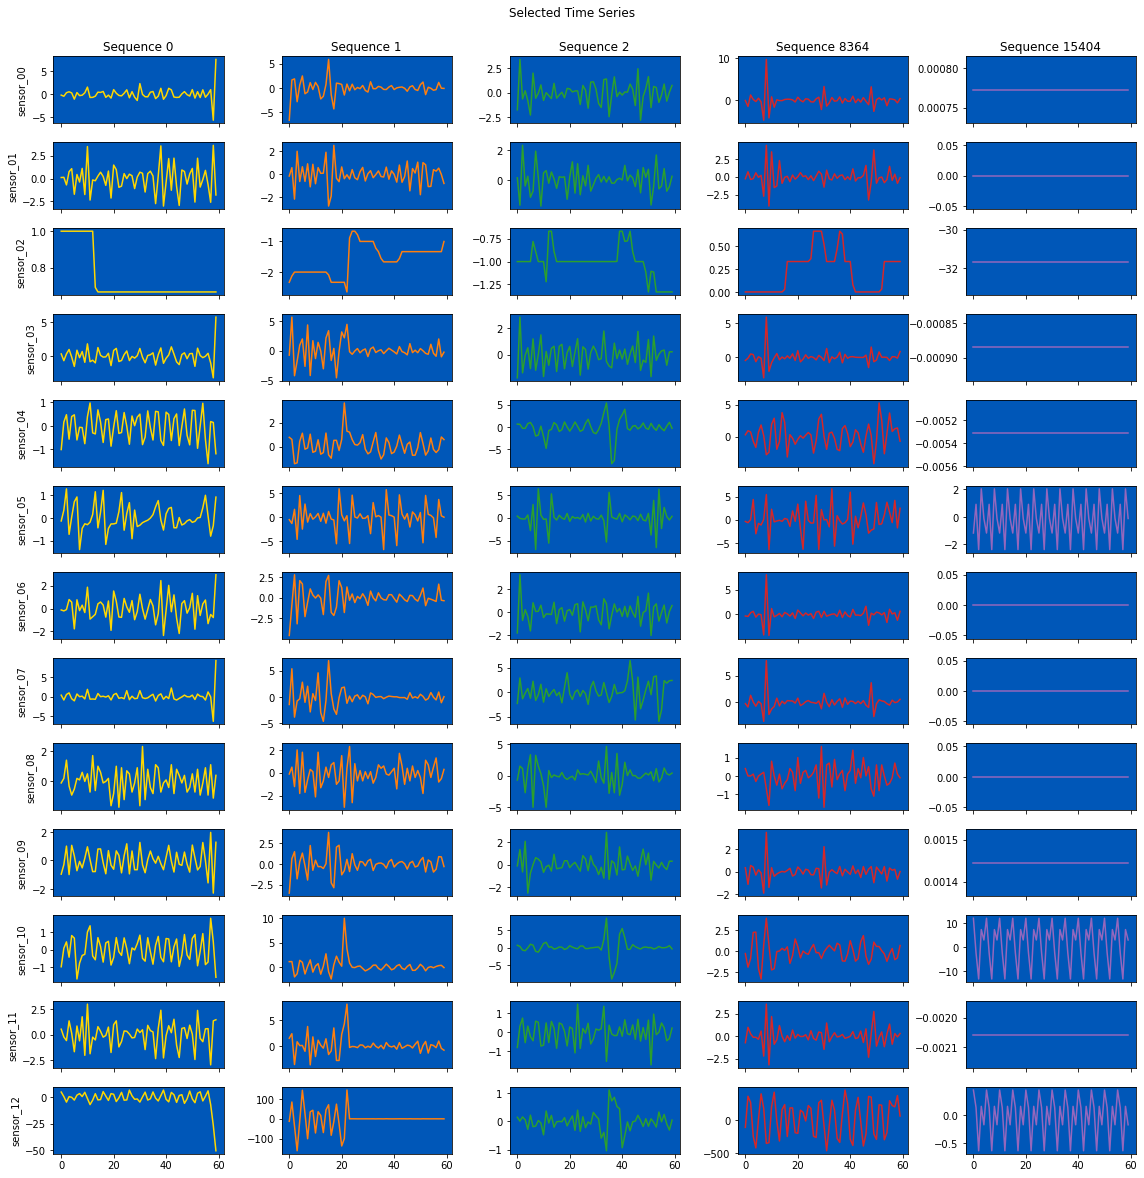

In [9]:
sequences = [0, 1, 2, 8364, 15404]
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(16, 16))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f"sensor_{sensor:02d}"
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train[train.sequence == sequence][sensor_name],
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
        if sensor == 0: plt.title(f"Sequence {sequence}")
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Selected Time Series', y=1.02)
plt.show()

In the diagrams above, we see:
- Most time series have a waveform with a high frequency. "High frequency" means that the value changes between positive and negative almost at every sampling step.
- Amplitude matters: For sequence 1 (orange), most waveforms have a higher amplitude during the first half of the time series than during the second half. For some sensors of sequence 0 (yellow), amplitude increases just two or three steps before the end of the time series.
- Sensor_02 (the one with the discrete levels) changes level only from time to time.
- At least one sequence (number 15404) doesn't follow the general pattern; some of its sensors have a constant value.
- The waveform of sensor_12 (bottommost diagram) has widely varying amplitudes: From less than 1 (sequence 2) up to 500 (sequence 8364).

**Insight:**
- Feature engineering should detect the changes in amplitude somehow.
- Measuring the base frequency of the time series probably won't be very useful.
- Feature engineering for sensor_02 will differ from the other sensors.
- We should check for sensors which return a constant value; maybe this can be used as a feature.
 
## Stuck at a constant

For every sensor we'll count the sequences which have the sensor stuck at a constant value, and we determine the average label:

In [10]:
# For every sensor: count the sequences where the sensor is stuck at a constant value
def stuck_at_constant(seq):
    return seq.min() == seq.max()

for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    stuck_sequences = train.groupby('sequence')[sensor_name].apply(stuck_at_constant)
    print(f"{sensor_name}: {stuck_sequences.sum():4d}   {train_labels[stuck_sequences].state.mean()}")

sensor_00:   44   0.0
sensor_01:   44   0.0
sensor_02: 1280   0.04609375
sensor_03:   44   0.0
sensor_04:   25   0.0
sensor_05:    0   nan
sensor_06:   44   0.0
sensor_07:   44   0.0
sensor_08:   44   0.0
sensor_09:   44   0.0
sensor_10:    0   nan
sensor_11:   44   0.0
sensor_12:   19   0.0


**Insight:**
- If a sensor is stuck at a constant value for the whole sequence, in most cases we may predict a state of 0. This method gives the correct prediction for more than 1000 training sequences.

# Pivot form of the data

We can pivot the dataframe so that every sequence corresponds to one row. In this pivoted dataframe, every row contains 13 sensor values for 60 time steps, i.e. 780 features. This pivot form of the dataframe can be useful for some data transformations:

In [11]:
train_pivoted = train.pivot(index=['sequence', 'subject'], columns='step', values=[col for col in train.columns if 'sensor_' in col])
train_pivoted

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   
...                    ...       ...       ...       ...       ...       ...   
25963    558     -1.441267  2.359351 -0.881762  1.299073 -0.862442 -1.428130   
25964    297      0.996909  0.415765  1.874034 -5.220247  2.927357 -0.311437   
25965    129     -0.097372 -0.860896  0.928903  0.750386  1.346986 -3.422720   
25966    170     -0.357032 -1.603555 -0.296754  0.273570  0.462133  0.244977   
25967    327     -0.313756  0.392581 -0.554096  0.070325 -0.258114  0.095054   

                                                          ...  sensor_12  \
step                    6         7         8         9   ...         50   
sequence subject                                          ...              
0        47       0.350850 -0.304482 -0.216383  0.303709  ...  -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ...  -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ...  -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...   0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...   0.001705   
...                    ...       ...       ...       ...  ...        ...   
25963    558      0.125193  2.119784  0.208655  1.847759  ...   0.049020   
25964    297      0.496909  0.372488 -0.341577 -0.565688  ...  36.889173   
25965    129      0.983771  2.818393 -1.460587 -1.988408  ...   2.394714   
25966    170     -0.341577 -0.229521  0.877125 -1.197063  ...  14.010656   
25967    327      0.387172 -0.824575  0.471406 -0.037094  ...   0.909207   

                                                                         \
step                     51         52         53         54         55   
sequence subject                                                          
0        47       -5.306479   3.621057   4.965047  -3.615090   0.791134   
1        66        0.234868   0.030691   0.037511  -0.120205   0.056692   
2        66        0.091645  -0.028986  -0.202472   0.332481  -0.013214   
3        542      -0.045610  -0.098039  -0.049446   0.055840  -0.022165   
4        437      -0.050725  -0.025149   0.106138  -0.098465  -0.040068   
...                     ...        ...        ...        ...        ...   
25963    558      -0.089940   0.059250  -0.013640  -0.083973   0.026002   
25964    297      21.105286  -4.421142  16.871697  -4.326939 -13.625320   
25965    129      -0.677323   1.435209  -0.645780  -0.449275   0.271952   
25966    170      48.826939  25.958227  -7.077153 -12.375533   9.170077   
25967    327      -0.830776  -1.007246   1.064365   0.639812  -0.914749   

                                                             
step                    56         57         58         59  
sequence subject                                             
0        47       5.887042  -7.211424 -26.738704 -50.658994  
1        66       0.062234  -0.013640   0.098039  -0.115090  
2        66       0.245524  -0.091219  -0.306905   0.046036  
3        542      0.054135  -0.185422   0.311168  -0.166240  
4        437      0.135976   0.121910  -0.059676  -0.087809  
...                    ...        ...        ...        ...  
25963    558      0.036232  -0.042199   0.028986  -0.015772  
25964    297      9.957374 -13.389173 -17.123615   9.219523  
25965    129     -0.262575   0.713129  -1.378517   1.802217  
25966    170      6.789855 -15.28729

# Duplicated sequences

Using the pivoted dataframe, we can easily show that some subjects have duplicated sequences (i.e. if two sequences are equal, they belong to the same subject).

**Insight:**
- We can drop the duplicates, but with 22 duplicates out of 25967 sequences, this won't matter much. 

By the way, all these duplicates have sensor_00 stuck at 0.000773 and a label of 0.

In [12]:
temp = train_pivoted.sort_values(by=list(train_pivoted.columns))
duplicates_first = temp.duplicated(keep='first')
duplicates_last = temp.duplicated(keep='last')
temp['duplicates_first'] = duplicates_first
temp['duplicates_last'] = duplicates_last
duplicates = temp[duplicates_first | duplicates_last]
display(duplicates)

print()
print('All these sequences have sensor_00 stuck at 0.000773:', duplicates['sensor_00'].apply(stuck_at_constant).all())

print()
print(f'Labels of the duplicates: {list(train_labels.loc[duplicates.index.get_level_values(0)].state)}')

sensor_00                                                    \
step                     0         1         2         3         4         5   
sequence subject                                                               
5882     573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
16294    573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
346      573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1772     573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
14349    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
21524    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
3335     359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
9324     359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
16829    359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
25576    359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1957     401      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
4512     401      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
6428     234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
12958    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1586     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
10633    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1428     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
25450    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
2817     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
11926    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
36       573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
11560    573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   

                                                          ... sensor_12  \
step                     6         7         8         9  ...        52   
sequence subject                                          ...             
5882     573      0.000773  0.000773  0.000773  0.000773  ...  0.547315   
16294    573      0.000773  0.000773  0.000773  0.000773  ...  0.547315   
346      573      0.000773  0.000773  0.000773  0.000773  ...  0.561381   
1772     573      0.000773  0.000773  0.000773  0.000773  ...  0.561381   
14349    234      0.000773  0.000773  0.000773  0.000773  ...  0.031969   
21524    234      0.000773  0.000773  0.000773  0.000773  ...  0.031969   
3335     359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
9324     359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
16829    359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
25576    359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
1957     401      0.000773  0.000773  0.000773  0.000773  ... -0.616795   
4512     401      0.000773  0.000773  0.000773  0.000773  ... -0.616795   
6428     234      0.000773  0.000773  0.000773  0.000773  ...  1.187553   
12958    234      0.000773  0.000773  0.000773  0.000773  ...  1.187553   
1586     48       0.000773  0.000773  0.000773  0.000773  ...  0.029838   
10633    48       0.000773  0.000773  0.000773  0.000773  ...  0.029838   
1428     48       0.000773  0.000773  0.000773  0.000773  ... -0.084825   
25450    48       0.000773  0.000773  0.000773  0.000773  ... -0.084825   
2817     48       0.000773  0.000773  0.000773  0.000773  ... -0.159847   
11926    48       0.000773  0.000773  0.000773  0.000773  ... -0.159847   
36       573      0.000773  0.000773  0.000773  0.000773  ... -0.928389   
11560    573      0.000773  0.000773  0.000773  0.000773  ... -0.928389   

                                                                              \
step                    53        54        55        56    


All these sequences have sensor_00 stuck at 0.000773: True

Labels of the duplicates: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# PCA

In an EDA, I usually analyze the principal components of the data. With the many outliers here, however, the PCA is deceptive: The principal components are dominated by the outliers, and after outlier removal, the PCA looks completely different.

The effect is shown in the diagrams below: Before outlier removal (left), it seems like the first 50 principal components explain almost all the variance. After outlier removal (right), the first 50 principal components explain almost nothing.

**Insight:**
- Be cautious with PCAs whenever outliers are present!
- The correlation matrix has the same issue: If you see any correlations, you have to check whether only the outliers are correlated or all the data.

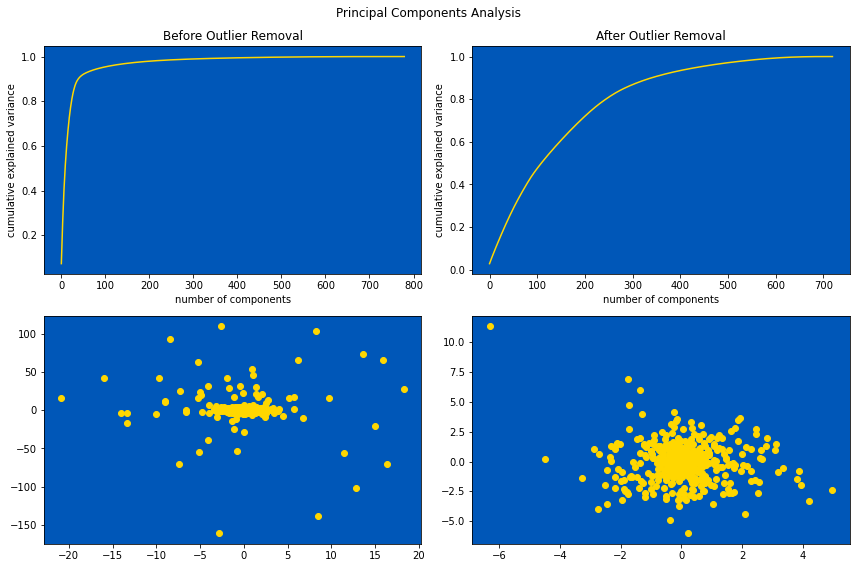

In [13]:
# Compute the PCA
# Outlier removal or input scaling may change the PCA completely
# whiten=True/False doesn't change the look of the diagrams (it only modifies the scale)
def plot_pca(df, col, title):
    """Plot cumulative variance and the first two components in column col of the figure."""
    pca = PCA()
    #pca.fit(StandardScaler().fit_transform(train_df.drop(columns=['id', 'target'])))
    Xt = pca.fit_transform(df.values)

    # Plot the cumulative explained variance
    plt.subplot(2, 2, col+1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title(title)

    # Scatterplot of the first two dimensions
    plt.subplot(2, 2, col+3)
    plt.scatter(Xt[0], Xt[1])
    
temp = train_pivoted.clip(train_pivoted.quantile(0.02, axis=0).values,
                          train_pivoted.quantile(0.98, axis=0).values, 
                          axis=1)
temp.pop('sensor_12')

plt.figure(figsize=(12, 8))
plot_pca(train_pivoted, 0, 'Before Outlier Removal')
plot_pca(temp, 1, 'After Outlier Removal')
plt.suptitle('Principal Components Analysis')
plt.tight_layout(h_pad=1.1)
plt.show()


# What next?

Having understood the EDA, you basically have two choices:
- You can follow the mainstream and develop a deep neural network,
- or, if you want to practice feature engineering and gradient boosting, you can implement something similar to my [Best Model Without NN](https://www.kaggle.com/ambrosm/tpsapr22-best-model-without-nn). The notebook shows some well-engineered features and demonstrates the correct way of cross-validating.